# Napovedovanje cen kripto valut, s pomočjo pogovorov na socialnih platformah

Podatkovno rudarjenje, projektna naloga, `18.5.2021`  
**`Nik Prinčič`**  
**`Jaka Škerjanc`**  
**`Erik Pahor`**


### Opis problema

Področje naše raziskave je trg kripto valut, bolj natančno kako pogovori na platformah kot sta Discord in Reddit, kjer si mnenja izmenjujeo predvsem kripto navdušenci, vplivajo na gibanje cen. Osredotočili se bomo predvsem na kriptovalute z nizko tržno kapitalizacijo (market cap).

Izbrane naloge, ki jih želimo raziskat:

* Ali lahko iz objav napovemo spremembo cene?
* Poiskati povezavo med ceno in popularnostjo na Reddit/Discord
* Ali kateri kovanci posebej izstopajo?
* Kako se je spreminajalo zanimanje za kripto valute?


### Pridobivanje podatkov

Podatke o objavah uporabnikov smo dobili na dveh platformah

* Discord: Tri skupnosti kripto navdušencev skupno preko 130.000 članov. Za obdobje od 1.2.2021 do 31.3.2021 smo pridobili skupno 1.700.000 sporočil. Ker Discord ne omogoča dostopa do sporočil preko kašnega vmesnika (npr. API), smo morali podatke pridobiti z programom [DiscordChatExporter](https://github.com/Tyrrrz/DiscordChatExporter), ki nam vrne .csv obliko. Da zmanjšamo velikost izbrišemo vse nepotrebne metapodatke. Na koncu nam ostane vsebina sporočila ter datum in čas.
* Reddit: Tukaj smo poiskali 4 "subreddite", kjer imajo vsak dan oziroma teden objavo v kateri uporabniki debatirajo o trenutno aktualnih zadevah. Pridobili smo komentarje iz 71 takih objav. Za to smo uporabili [PRAW: The Python Reddit API Wrapper](https://github.com/praw-dev/praw).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime
from collections import defaultdict

import os

BASE_PATH = os.path.abspath(os.path.curdir)
PRICE_DATA_DIR = os.path.join(BASE_PATH, "data/price_data/")
MENTIONS_COUNT_DIR = os.path.join(BASE_PATH, "data/date_count")

COLOR_MAIN = "#363A45"
COLOR_MA_5 = "#FF9800"
COLOR_MA_8 = "#E040FB"
COLOR_MA_13 = "#9C27B0"
COLOR_VOLUME = "#B2B5BE"

MIN_DATE = "2021-02-01 00:00:00"
MAX_DATE = "2021-04-05 03:00:00"

TITLE_SIZE = 20
AXES_LABELS_SIZE = 15

DATE_RANGE = pd.date_range(
    start=MIN_DATE,
    end=MAX_DATE,
    freq="2D",
)

plt.style.use("seaborn")

Primeri komentarjev ki smo jih pridobili.

In [4]:
import os
import pandas as pd
BASE_PATH = os.path.abspath(os.path.curdir)

data_discord = pd.read_csv(os.path.join(BASE_PATH, "data", "posts", "discord", "CryptoCurrencyFeb2021.csv"))
data_reddit = pd.read_csv(os.path.join(BASE_PATH, "data", "posts", "reddit", "CryptoMarkets", "weekly-discussion-megathread-march-14-2021-gmt0.csv"))

print("Discord")
print(data_discord[0:1], "\n")

print("Reddit")
print(data_reddit[0:1])

Discord
         date                                            content
0  1612134004  85% profit on GRT so far, looking good for .99... 

Reddit
         date                                 content  score
0  1615912537  ADA showing signs of upward divergence      4


Prikaz števila komentarjev od febuarja do konca marca.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


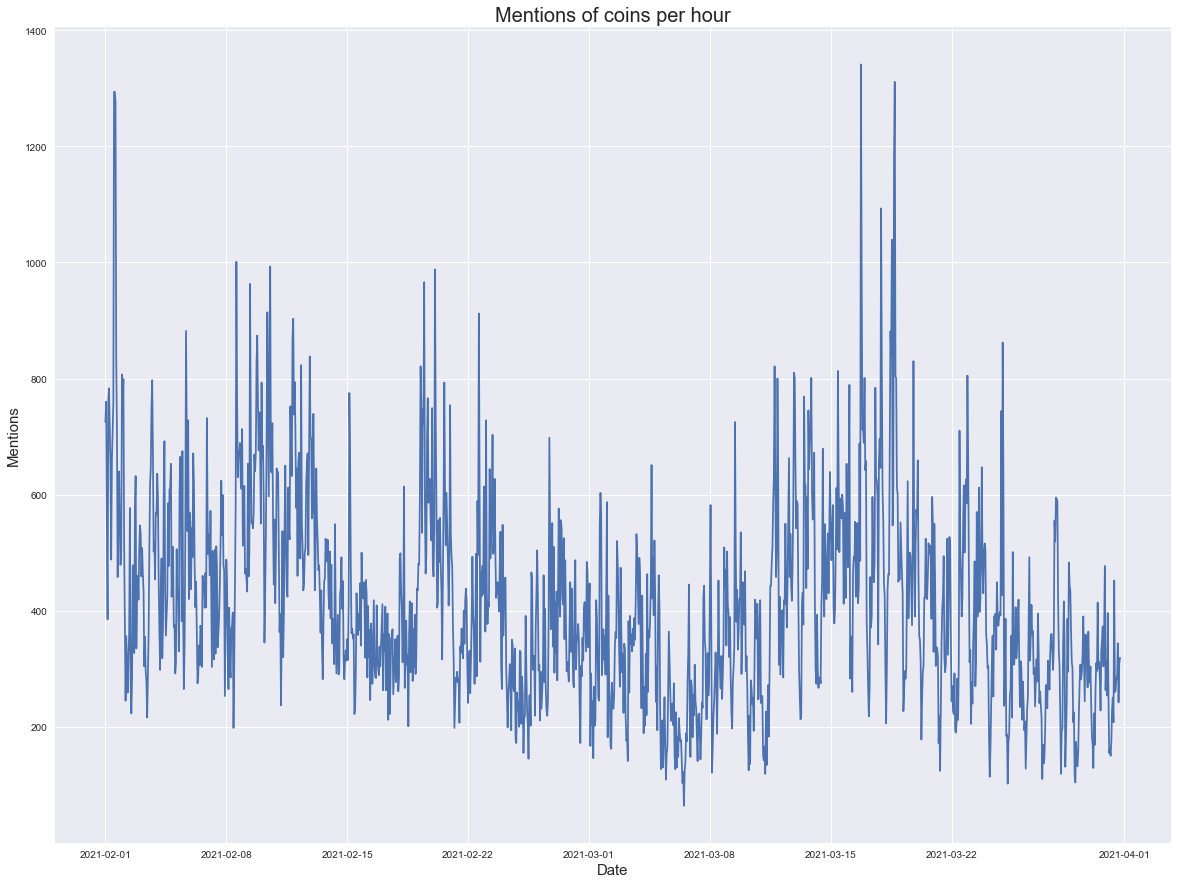

In [5]:
import matplotlib.dates as md
count_all = pd.read_csv(os.path.join(BASE_PATH, "data", "date_count_all.csv"))

dates=[datetime.datetime.fromtimestamp(ts) for ts in count_all["date"][0:1410]]
fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(dates,count_all["count"][0:1410])
ax.set_title("Mentions of coins per hour", fontsize=TITLE_SIZE)
ax.set_xlabel("Date", fontsize=AXES_LABELS_SIZE)
ax.set_ylabel("Mentions", fontsize=AXES_LABELS_SIZE)
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)

plt.show()

Iz grafa je videti, da je povprečno število omemb kovancev na dan okoli 500.

### Izvedene analize




Primerjava deleža omemb kovanca z deležem njegovega tržnega kapitala.

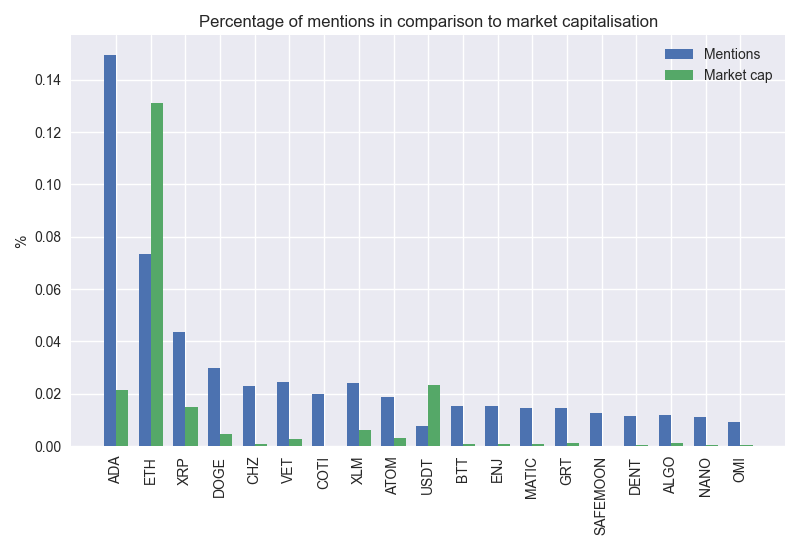

In [6]:
from IPython.display import Image
Image(filename=os.path.join(BASE_PATH, "visualization", "market_cap_vs_mentions.png"))

In [7]:
def date_parser(timestamp):
    return datetime.datetime.fromtimestamp(int(timestamp))

Naslednje smo od vseh gledanih kovancev izbrali najboljših 5%, kateri so imeli največ omemb.

Text(0, 0.5, 'Coin')

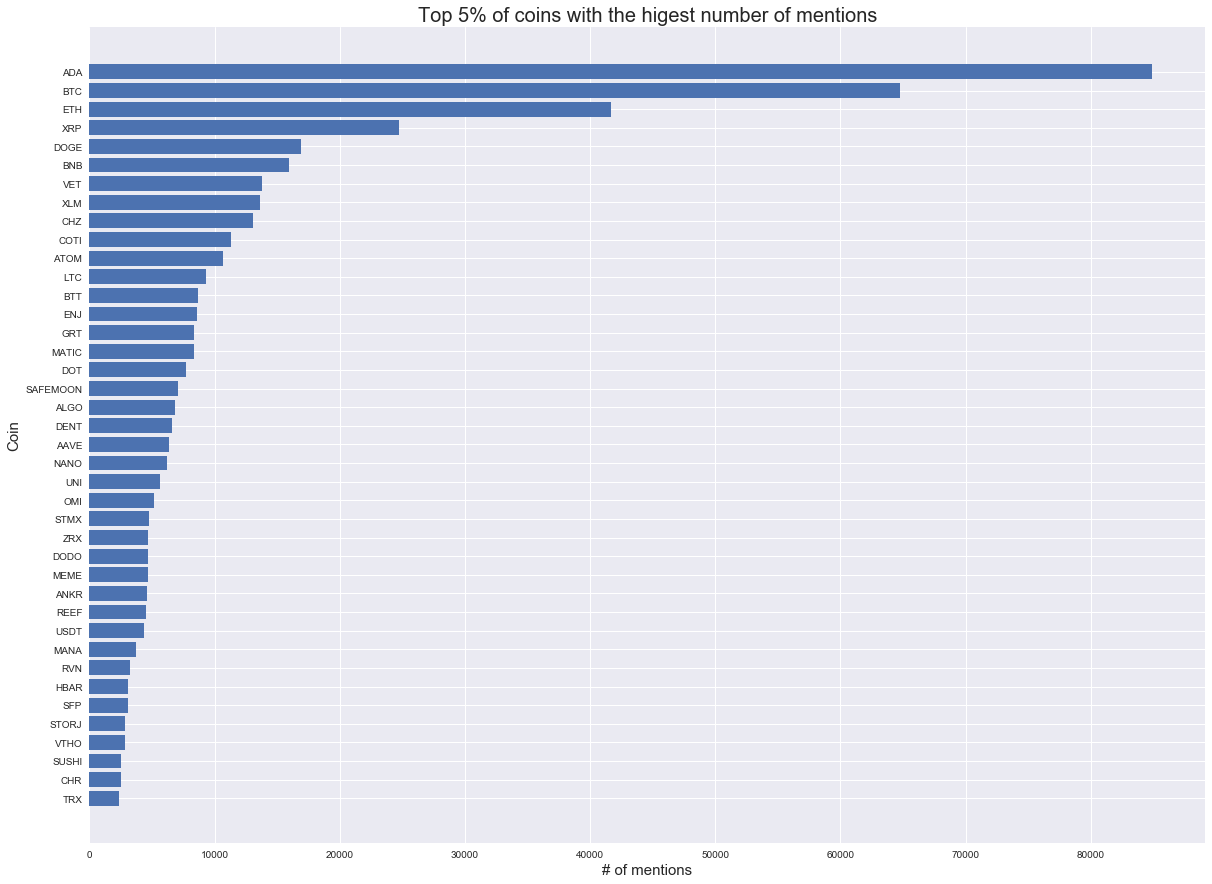

In [8]:
data = pd.read_csv(os.path.join(BASE_PATH, "data", "tracked_coins_details.csv"))
limit = data["count"].quantile(0.95)
data = data[data["count"] >= limit]
data = data.sort_values(by="count")

TRACKED_COINS = data["symbol"].array

fig, ax = plt.subplots(figsize=(20, 15))

ax.barh(data["symbol"], data["count"])
ax.set_title("Top 5% of coins with the higest number of mentions", fontsize=TITLE_SIZE)
ax.set_xlabel("# of mentions", fontsize=AXES_LABELS_SIZE)
ax.set_ylabel("Coin", fontsize=AXES_LABELS_SIZE)

Vzeli smo 4 kovance, ki imajo največjo spremebmo v ceni. Pogledali smo, kdaj so imeli najvišjo ter najnižjo ceno in načrtali še število omemb, da lahko vidimo, če lahko kaj predvidimo.

In [9]:
biggest_volume_diff = pd.DataFrame(
    columns=["coin", "min", "min_date", "max", "max_date", "diff", "diff_rel"]
)

for e in os.listdir(PRICE_DATA_DIR):
    if e not in TRACKED_COINS:
        continue

    df = pd.read_csv(os.path.join(PRICE_DATA_DIR, e, f"{e}_volume.csv"))
    min_ = df["volume"].min()
    max_ = df["volume"].max()
    min_date = df[df["volume"] == min_]["date"].array[0]
    max_date = df[df["volume"] == max_]["date"].array[0]
    diff = max_ - min_
    if min_ == 0:
        diff_rel = np.inf
    elif max_date > min_:
        diff_rel = (max_ / min_) - 1
    else:
        diff_rel = -((max_ / min_) - 1)
    biggest_volume_diff = biggest_volume_diff.append(
        {
            "coin": e,
            "min": min_,
            "min_date": min_date,
            "max": max_,
            "max_date": max_date,
            "diff": diff,
            "diff_rel": diff_rel * 100,
        },
        ignore_index=True,
    )
biggest_volume_diff = biggest_volume_diff.sort_values(by="diff_rel", ascending=False)

biggest_price_diff = pd.DataFrame(
    columns=["coin", "min", "min_date", "max", "max_date", "diff", "diff_rel"]
)

for e in os.listdir(PRICE_DATA_DIR):
    if e not in TRACKED_COINS:
        continue

    df = pd.read_csv(os.path.join(PRICE_DATA_DIR, e, f"{e}_price.csv"))
    min_ = df["price"].min()
    max_ = df["price"].max()
    min_date = df[df["price"] == min_]["date"].array[0]
    max_date = df[df["price"] == max_]["date"].array[0]
    diff = max_ - min_
    if min_ == 0:
        diff_rel = np.inf
    elif max_date > min_:
        diff_rel = (max_ / min_) - 1
    else:
        diff_rel = -((max_ / min_) - 1)
    biggest_price_diff = biggest_price_diff.append(
        {
            "coin": e,
            "min": min_,
            "min_date": min_date,
            "max": max_,
            "max_date": max_date,
            "diff": diff,
            "diff_rel": diff_rel * 100,
        },
        ignore_index=True,
    )
biggest_price_diff = biggest_price_diff.sort_values(by="diff_rel", ascending=False)

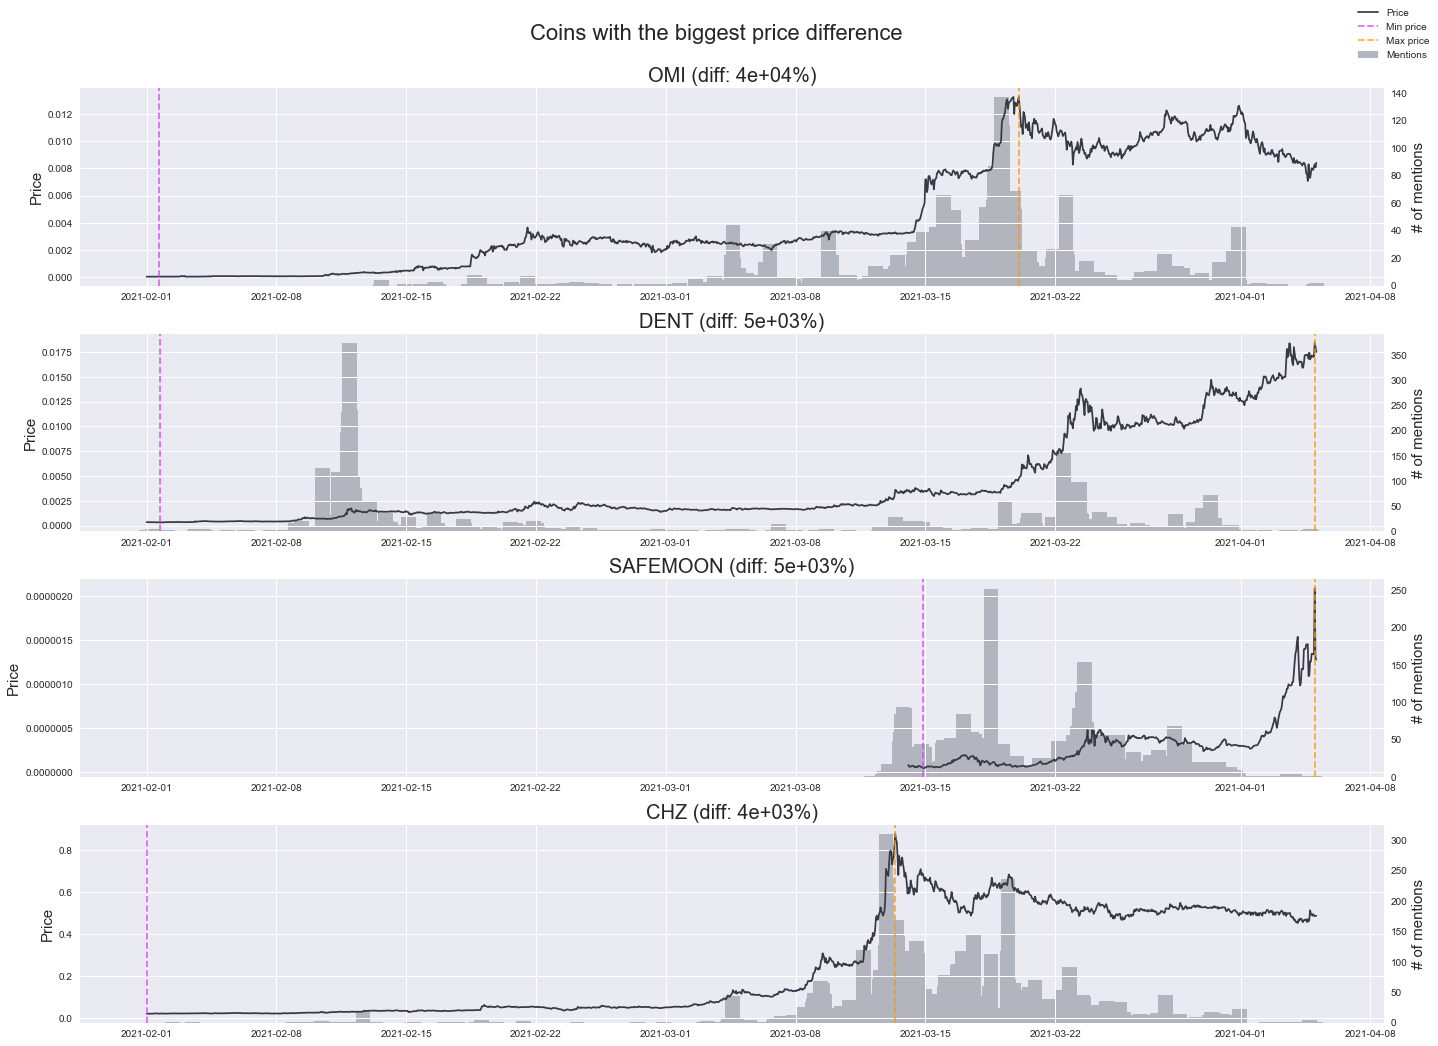

In [10]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))

for i, e in enumerate(biggest_price_diff.iloc[0:4].iterrows()):
    coin = e[1]["coin"]
    mentions_data = pd.read_csv(
        os.path.join(MENTIONS_COUNT_DIR, f"{e[1]['coin']}.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    price_data = pd.read_csv(
        os.path.join(PRICE_DATA_DIR, e[1]["coin"], f"{e[1]['coin']}_price.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    ax_bar = ax[i].twinx()
    ax_bar.bar(mentions_data.index, mentions_data["count"], color=COLOR_VOLUME, label="Mentions")
    ax[i].plot(price_data["price"], color=COLOR_MAIN, label="Price")

    ax[i].axvline(
        date_parser(e[1]["min_date"]), color=COLOR_MA_8, alpha=0.8, linestyle="--", label="Min price"
    )
    ax[i].axvline(
        date_parser(e[1]["max_date"]), color=COLOR_MA_5, alpha=0.8, linestyle="--", label="Max price"
    )

    ax[i].set_zorder(ax_bar.get_zorder() + 1)
    ax[i].patch.set_visible(False)
    ax[i].set_title(f"{coin} (diff: {e[1]['diff_rel']:.0}%)", fontsize=TITLE_SIZE)
    ax[i].set_ylabel("Price", fontsize=AXES_LABELS_SIZE)

    ax_bar.patch.set_visible(True)
    ax_bar.grid(b=None)
    ax_bar.set_ylabel("# of mentions", fontsize=AXES_LABELS_SIZE)

l, h = ax[0].get_legend_handles_labels()
l2, h2 = ax_bar.get_legend_handles_labels()

fig.legend(l + l2, h + h2)
fig.suptitle("Coins with the biggest price difference", fontsize=22)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Iz grafa lahko vidimo, da se tik po narastku števila omemb tudi cena dvigne, ko pa vpade število omemb cena stagnira ali pa celo pade.

Naslednje smo vzeli 4 kovance, ki imajo največjo spremebmo v številu kovancev v cirkulaciji. Pogledali smo, kdaj so imeli najvišji ter najnižji volumen in narisali še število omemb, da lahko vidimo, če se je število kovancev v cirkualciji spremenilo po narastku ali padcu omemb.

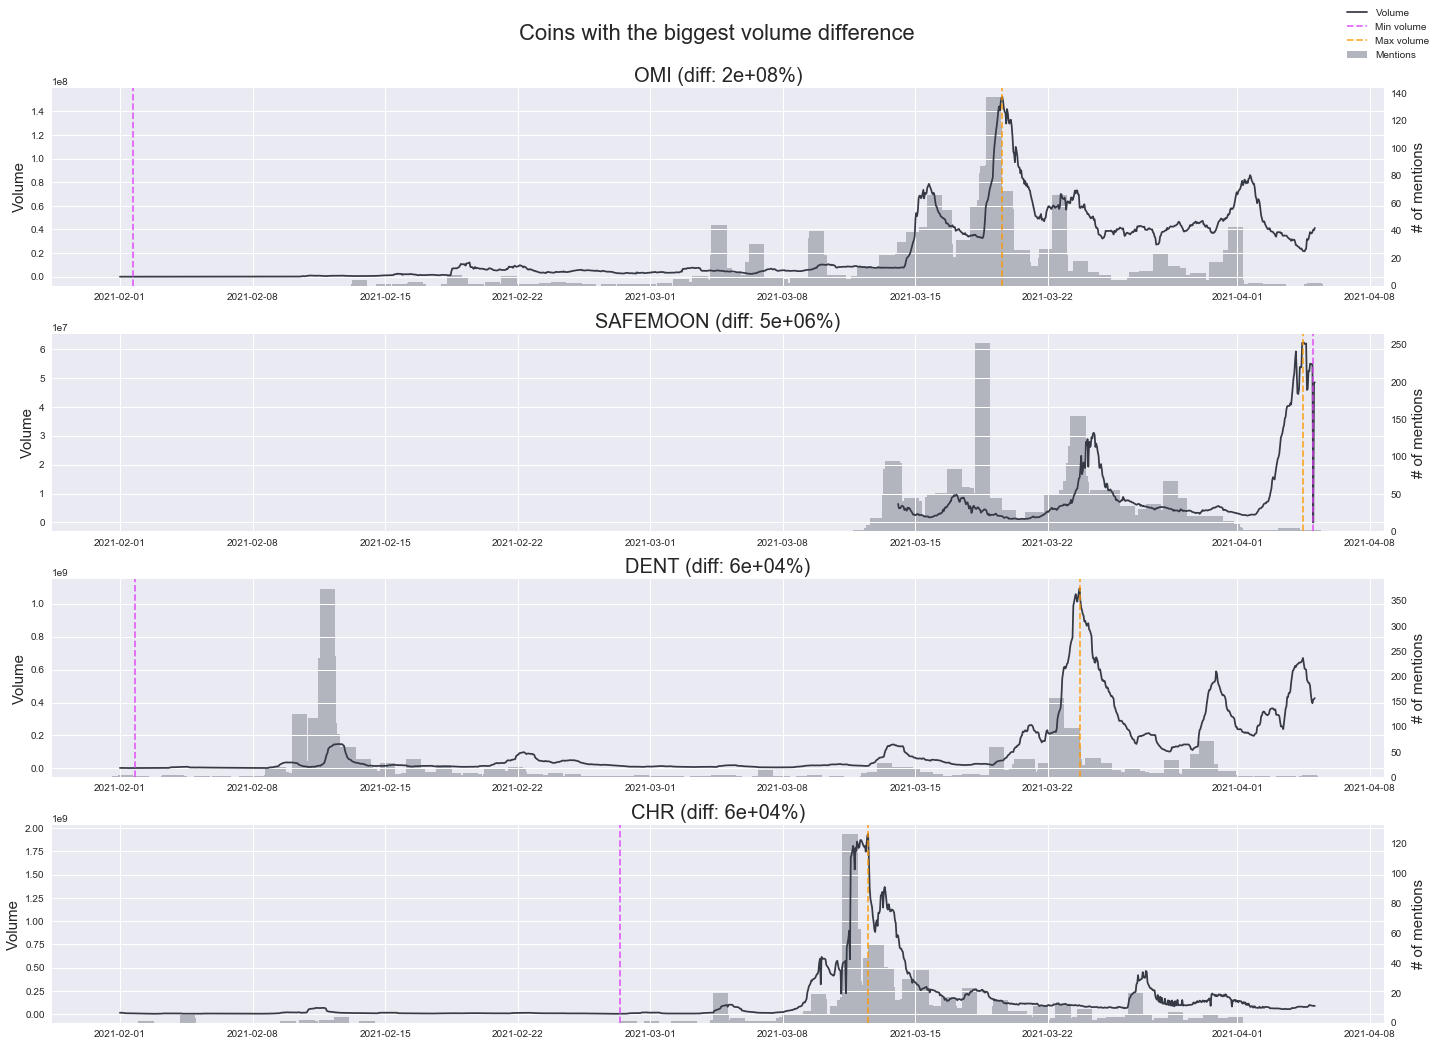

In [11]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))

for i, e in enumerate(
    biggest_volume_diff[biggest_volume_diff["max"] != 0].iloc[0:4].iterrows()
):
    coin = e[1]["coin"]
    mentions_data = pd.read_csv(
        os.path.join(MENTIONS_COUNT_DIR, f"{e[1]['coin']}.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    volume_data = pd.read_csv(
        os.path.join(PRICE_DATA_DIR, e[1]["coin"], f"{e[1]['coin']}_volume.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    ax_bar = ax[i].twinx()
    ax_bar.bar(mentions_data.index, mentions_data["count"], color=COLOR_VOLUME, label="Mentions")
    ax[i].plot(volume_data["volume"], color=COLOR_MAIN, label="Volume")

    ax[i].axvline(
        date_parser(e[1]["min_date"]), color=COLOR_MA_8, alpha=0.8, linestyle="--", label="Min volume"
    )
    ax[i].axvline(
        date_parser(e[1]["max_date"]), color=COLOR_MA_5, alpha=0.8, linestyle="--", label="Max volume"
    )

    ax[i].set_zorder(ax_bar.get_zorder() + 1)
    ax[i].patch.set_visible(False)
    ax[i].set_title(f"{coin} (diff: {e[1]['diff_rel']:.0}%)", fontsize=TITLE_SIZE)
    ax[i].set_ylabel("Volume", fontsize=AXES_LABELS_SIZE)

    ax_bar.patch.set_visible(True)
    ax_bar.grid(b=None)
    ax_bar.set_ylabel("# of mentions", fontsize=AXES_LABELS_SIZE)

l, h = ax[0].get_legend_handles_labels()
l2, h2 = ax_bar.get_legend_handles_labels()

fig.legend(l + l2, h + h2)
fig.suptitle("Coins with the biggest volume difference", fontsize=22)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Na grafih se vidi, da se ponavadi število kovancev v cirkulaciji poveča po narastku omemb, kar pomeni, da ljudje kupujejo kovance o katerih se trenutno govori. Lahko pa se tudi poveča število omemb, ko število kovancev začne padati, ker jih vsi prodajajo.

Pogledali smo še spremembe cen najbolj omenjenih kovancev.

<ipython-input-12-ab436f76a728>:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  min_date = biggest_price_diff[biggest_volume_diff["coin"] == e]["min_date"]
<ipython-input-12-ab436f76a728>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  max_date = biggest_price_diff[biggest_volume_diff["coin"] == e]["max_date"]


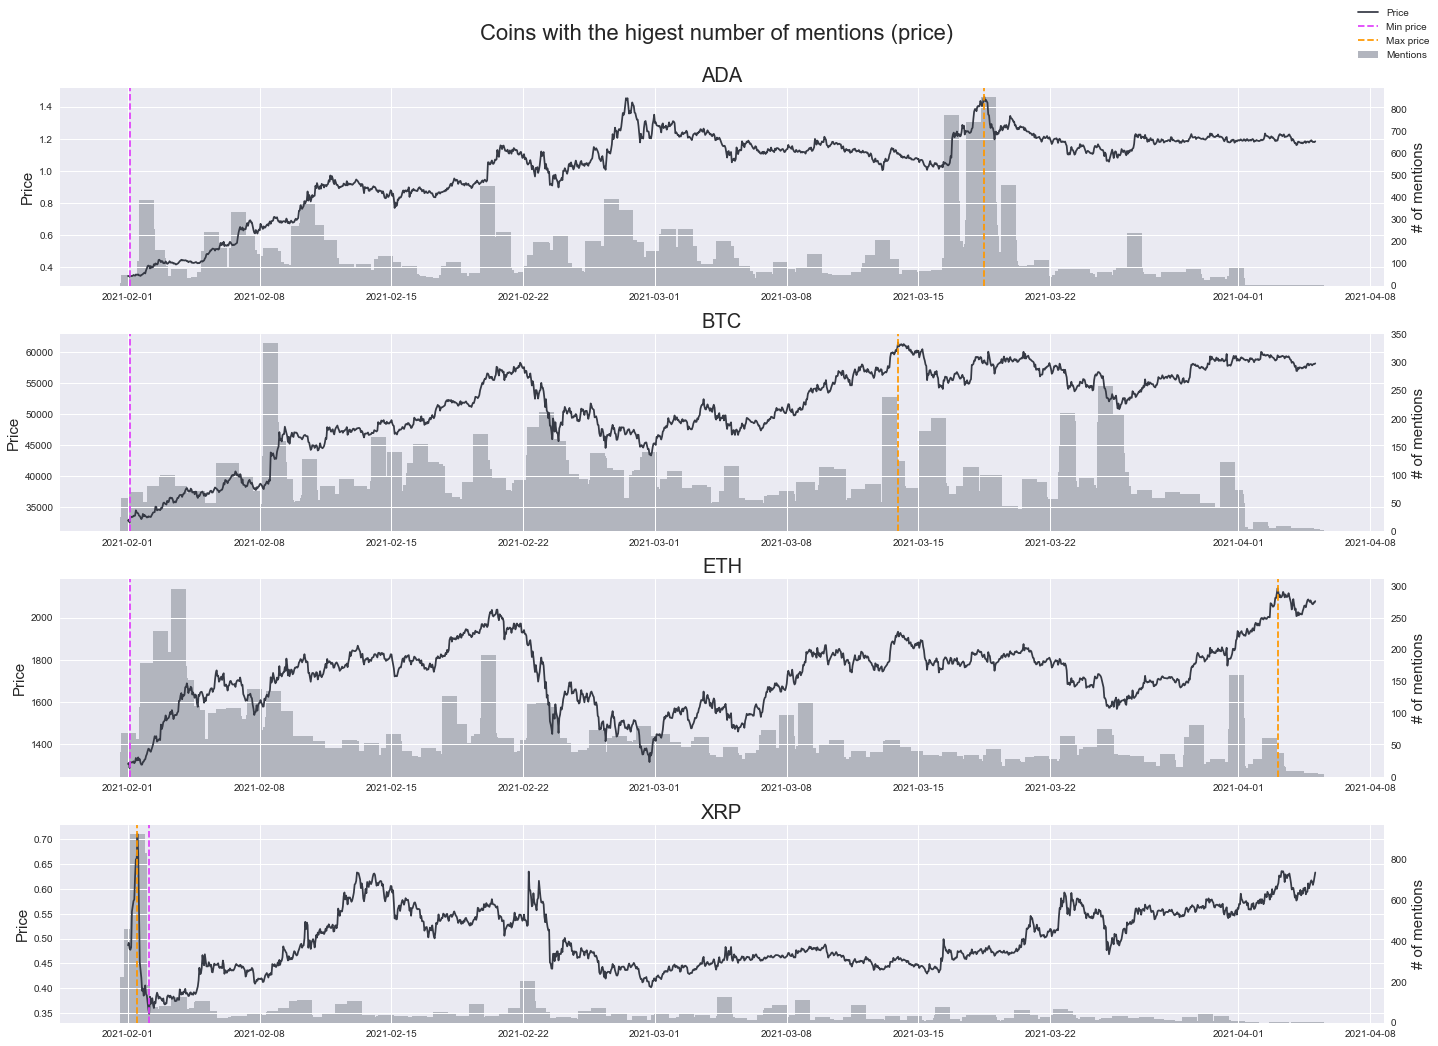

In [12]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))


for i, e in enumerate(TRACKED_COINS[:-5:-1]):
    coin = e
    mentions_data = pd.read_csv(
        os.path.join(MENTIONS_COUNT_DIR, f"{coin}.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    price_data = pd.read_csv(
        os.path.join(PRICE_DATA_DIR, coin, f"{coin}_price.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    ax_bar = ax[i].twinx()
    ax_bar.bar(mentions_data.index, mentions_data["count"], color=COLOR_VOLUME, label="Mentions")
    ax[i].plot(price_data["price"], color=COLOR_MAIN, label="Price")

    min_date = biggest_price_diff[biggest_volume_diff["coin"] == e]["min_date"]
    max_date = biggest_price_diff[biggest_volume_diff["coin"] == e]["max_date"]

    ax[i].axvline(date_parser(min_date), color=COLOR_MA_8, linestyle="--", label="Min price")
    ax[i].axvline(date_parser(max_date), color=COLOR_MA_5, linestyle="--", label="Max price")

    ax[i].set_zorder(ax_bar.get_zorder() + 1)
    ax[i].patch.set_visible(False)
    ax[i].set_title(f"{coin}", fontsize=TITLE_SIZE)
    ax[i].set_ylabel("Price", fontsize=AXES_LABELS_SIZE)

    ax_bar.patch.set_visible(True)
    ax_bar.grid(b=None)
    ax_bar.set_ylabel("# of mentions", fontsize=AXES_LABELS_SIZE)

l, h = ax[0].get_legend_handles_labels()
l2, h2 = ax_bar.get_legend_handles_labels()

fig.legend(l + l2, h + h2)
fig.suptitle("Coins with the higest number of mentions (price)", fontsize=22)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Tudi tukaj se vidi, da se cena kovancev in število omemb kar dobro sovpadata. Ko naraste število omemb cena narašča in ko se število omemb zmanjša, cena pada.

Začrtali smo tudi število kovancev v cirkulaciji za najbolj omenjene kovance.

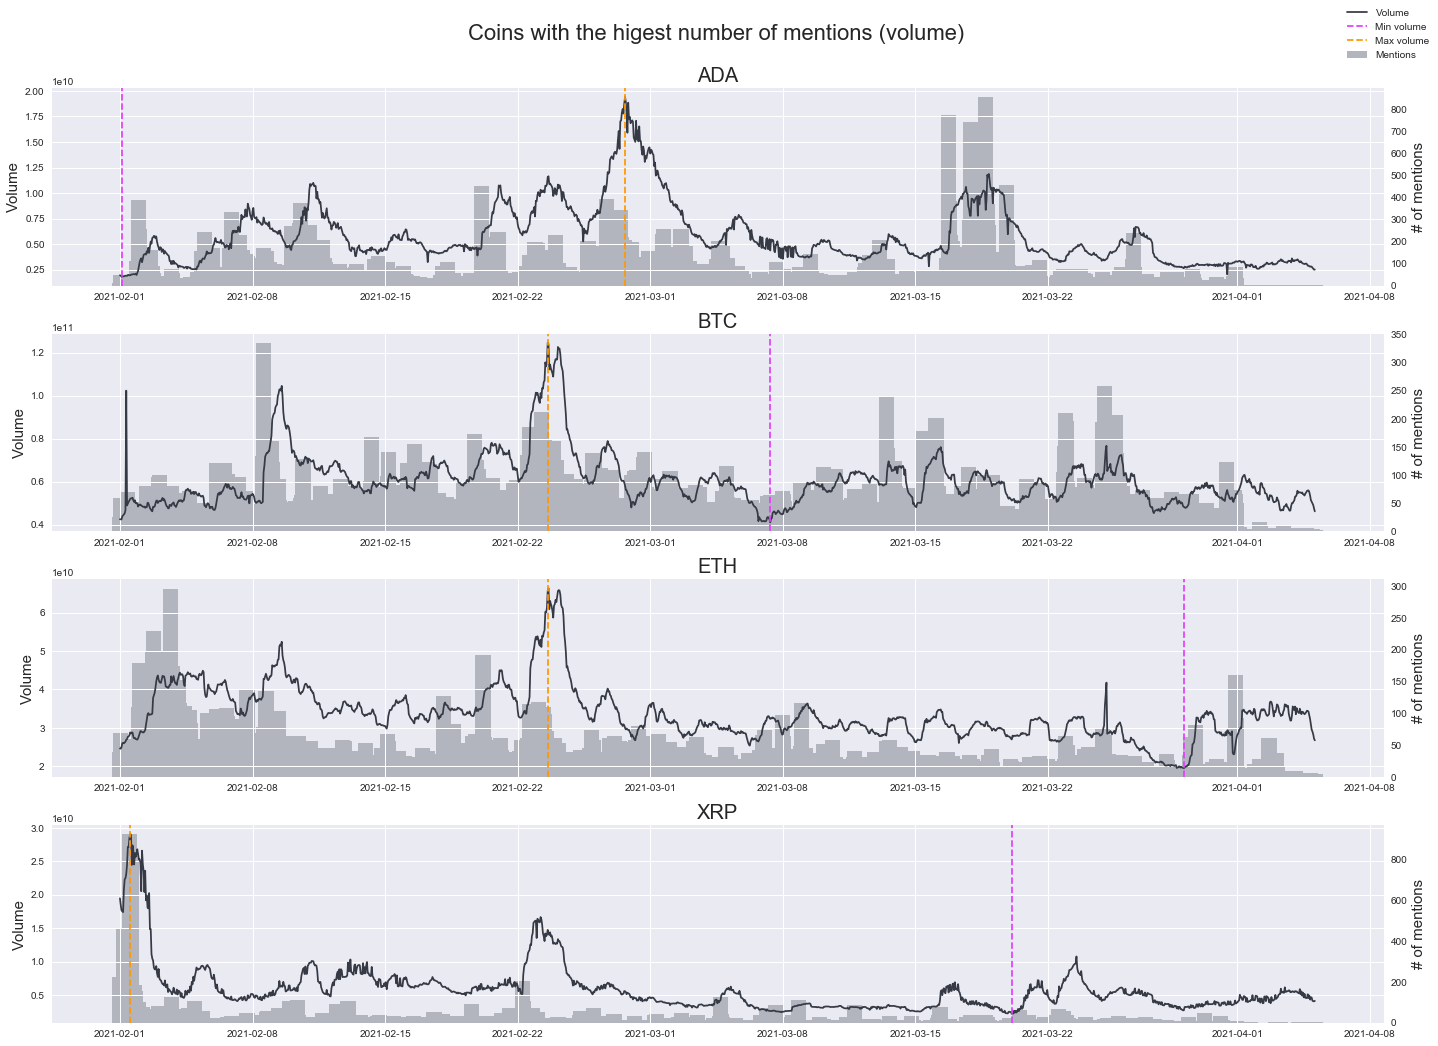

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))


for i, e in enumerate(TRACKED_COINS[:-5:-1]):
    coin = e
    mentions_data = pd.read_csv(
        os.path.join(MENTIONS_COUNT_DIR, f"{coin}.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    volume_data = pd.read_csv(
        os.path.join(PRICE_DATA_DIR, coin, f"{coin}_volume.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    ax_bar = ax[i].twinx()
    ax_bar.bar(mentions_data.index, mentions_data["count"], color=COLOR_VOLUME, label="Mentions")
    ax[i].plot(volume_data["volume"], color=COLOR_MAIN, label="Volume")

    min_date = biggest_volume_diff[biggest_volume_diff["coin"] == e]["min_date"]
    max_date = biggest_volume_diff[biggest_volume_diff["coin"] == e]["max_date"]

    ax[i].axvline(date_parser(min_date), color=COLOR_MA_8, linestyle="--", label="Min volume")
    ax[i].axvline(date_parser(max_date), color=COLOR_MA_5, linestyle="--", label="Max volume")

    ax[i].set_zorder(ax_bar.get_zorder() + 1)
    ax[i].patch.set_visible(False)
    ax[i].set_title(f"{coin}", fontsize=TITLE_SIZE)
    ax[i].set_ylabel("Volume", fontsize=AXES_LABELS_SIZE)

    ax_bar.patch.set_visible(True)
    ax_bar.grid(b=None)
    ax_bar.set_ylabel("# of mentions", fontsize=AXES_LABELS_SIZE)


l, h = ax[0].get_legend_handles_labels()
l2, h2 = ax_bar.get_legend_handles_labels()

fig.legend(l + l2, h + h2)
fig.suptitle("Coins with the higest number of mentions (volume)", fontsize=22)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Tudi tukaj se vidi, da volumen kovancev v cirkulaciji lepo narašča in pada s številom omemb na socialnih platformah.

Bolj podrobno smo analizirali kriptovaluto Cardano (ADA), saj je ta imela od vseh altcoinov največ omemb.

In [14]:
def add_rolling_mean(
    df, attrs: list, intervals: list, group_by=None, min_eq_max=True, min_w=1
):
    df = df.copy()
    for attr in attrs:
        for interval in intervals:
            interval *= 4
            if min_eq_max:
                min_w = interval
            if group_by != None:
                df[f"{attr}_MA_{int(interval/4)}"] = df.groupby(group_by)[
                    attr
                ].transform(lambda x: x.rolling(interval, min_w).mean())
            else:
                df[f"{attr}_MA_{int(interval/4)}"] = df[attr].transform(
                    lambda x: x.rolling(interval, min_w).mean()
                )
    return df

In [17]:
TRACKED_COIN = "ADA"
price_data = pd.read_csv(
    open(os.path.join(PRICE_DATA_DIR, TRACKED_COIN, f"{TRACKED_COIN}_price.csv"), "r"),
    parse_dates=True,
    date_parser=date_parser,
    index_col="date",
)

volume_data = pd.read_csv(
    open(os.path.join(PRICE_DATA_DIR, TRACKED_COIN, f"{TRACKED_COIN}_volume.csv"), "r"),
    parse_dates=True,
    date_parser=date_parser,
    index_col="date",
)

mentions_data = pd.read_csv(
    open(os.path.join(MENTIONS_COUNT_DIR, f"{TRACKED_COIN}.csv"), "r"),
    parse_dates=True,
    date_parser=date_parser,
    index_col="date",
)

price_data = add_rolling_mean(price_data, ["price"], [5, 8, 13], min_eq_max=False)
mentions_data = add_rolling_mean(mentions_data, ["count"], [5, 8, 13], min_eq_max=False)

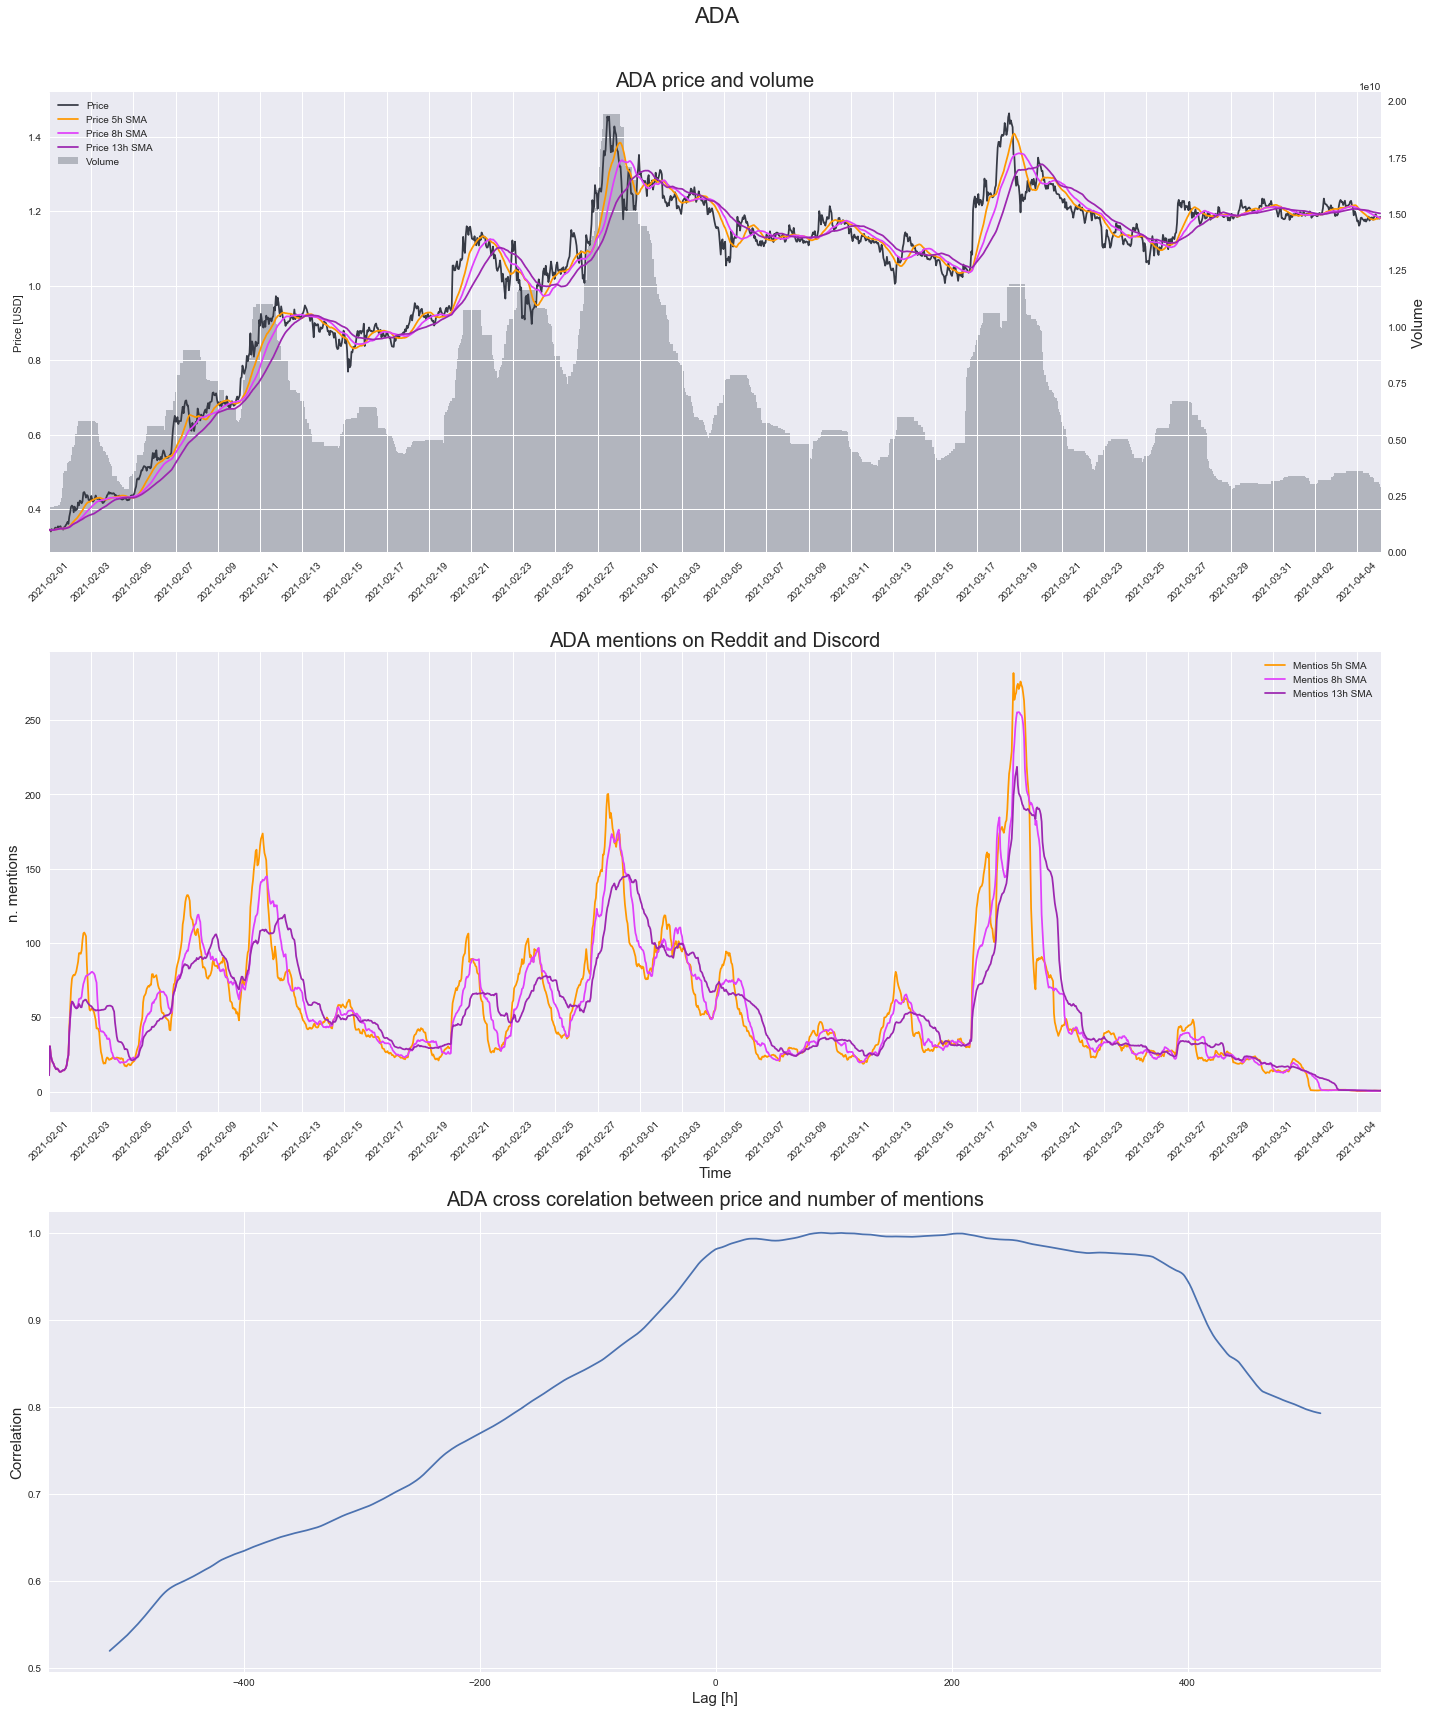

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(20, 25))

date_range = pd.date_range(
    start=MIN_DATE,
    end=MAX_DATE,
    freq="2D",
)

ax[0].plot(price_data["price"], color=COLOR_MAIN, label="Price")
ax[0].plot(price_data["price_MA_5"], color=COLOR_MA_5, label="Price 5h SMA")
ax[0].plot(price_data["price_MA_8"], color=COLOR_MA_8, label="Price 8h SMA")
ax[0].plot(price_data["price_MA_13"], color=COLOR_MA_13, label="Price 13h SMA")

ax2 = ax[0].twinx()
ax2.bar(
    height=volume_data["volume"],
    x=volume_data.index,
    color=COLOR_VOLUME,
    label="Volume",
)

ax[1].plot(mentions_data["count_MA_5"], color=COLOR_MA_5, label="Mentios 5h SMA")
ax[1].plot(mentions_data["count_MA_8"], color=COLOR_MA_8, label="Mentios 8h SMA")
ax[1].plot(mentions_data["count_MA_13"], color=COLOR_MA_13, label="Mentios 13h SMA")

ax[0].set_xlim(
    [
        datetime.datetime.fromisoformat(MIN_DATE),
        datetime.datetime.fromisoformat(MAX_DATE),
    ]
)

ax[1].set_xlim(
    [
        datetime.datetime.fromisoformat(MIN_DATE),
        datetime.datetime.fromisoformat(MAX_DATE),
    ]
)

ax[0].xaxis.set_ticks(date_range)
ax[0].set_xticklabels(
    [pd.to_datetime(e).date() for e in date_range.values], rotation=45
)

ax[1].xaxis.set_ticks(date_range)
ax[1].set_xticklabels(
    [pd.to_datetime(e).date() for e in date_range.values], rotation=45
)

corr = np.correlate(price_data["price"], mentions_data["count_MA_5"], "full")[
    1000:-1000
]

corr = corr / corr.max()
lags = np.arange(-corr.size / 2, corr.size / 2, 1)
ax[2].plot(lags, corr)

h1, l1 = ax[0].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax[0].legend(h1 + h2, l1 + l2, loc=2)

ax[1].legend(loc=0)

ax[0].set_zorder(ax2.get_zorder() + 1)
ax[0].patch.set_visible(False)
ax[0].set_ylabel("Price [USD]")

ax2.patch.set_visible(True)
ax2.set_title(f"{TRACKED_COIN} price and volume", fontsize=TITLE_SIZE)
ax2.set_ylabel("Volume", fontsize=AXES_LABELS_SIZE)
ax2.set_xlabel("Time", fontsize=AXES_LABELS_SIZE)
ax2.grid(b=None)

ax[1].set_title(f"{TRACKED_COIN} mentions on Reddit and Discord", fontsize=TITLE_SIZE)
ax[1].set_ylabel("n. mentions", fontsize=AXES_LABELS_SIZE)
ax[1].set_xlabel("Time", fontsize=AXES_LABELS_SIZE)

ax[2].set_title(
    f"{TRACKED_COIN} cross corelation between price and number of mentions",
    fontsize=TITLE_SIZE,
)
ax[2].set_ylabel("Correlation", fontsize=AXES_LABELS_SIZE)
ax[2].set_xlabel("Lag [h]", fontsize=AXES_LABELS_SIZE)

fig.suptitle(TRACKED_COIN, fontsize=22)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Na prve grafu je prikazano gibanje cene, 5, 8 in 13 urno SMA (simple moving average) gibanje cene ter tržni volumen kovanca. Na drugem grafu pa je prikazano gibanje omemb kovanca na družbenih omrežjih Reddit in Discord. Na tretjem grafu pa je prikazan cross corelation med ceno in številom omemb, kot lahko razberemo z grafa je korelacija najvišja med zamiki 0 in 200, kar pomeni, cena vpliva na število omemb in ne obratno. 

Za vse opazovane kovance smo poizkusili nbarediti tudi predikcijo, ki bi napovedovala premik cene (samo premik in ne smer premika +/-). Predikcijo smo realizirali z detekcijo skokov števila omemb skozi čas, za detekcijo skokov pa smo uporabili z-score peek detection algoritem 

[Brakel, J.P.G. van (2014). "Robust peak detection algorithm using z-scores". Stack Overflow. Available at: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/22640362#22640362 (version: 2020-11-08).] 

in s tem pridobili točke na grafu, ki naj bi napovedovale premik cene.

In [24]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0] * len(y)
    stdFilter = [0] * len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i - 1]) > threshold * stdFilter[i - 1]:
            if y[i] > avgFilter[i - 1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i - 1]
            avgFilter[i] = np.mean(filteredY[(i - lag + 1) : i + 1])
            stdFilter[i] = np.std(filteredY[(i - lag + 1) : i + 1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i - lag + 1) : i + 1])
            stdFilter[i] = np.std(filteredY[(i - lag + 1) : i + 1])

    return dict(
        signals=np.asarray(signals),
        avgFilter=np.asarray(avgFilter),
        stdFilter=np.asarray(stdFilter),
    )

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


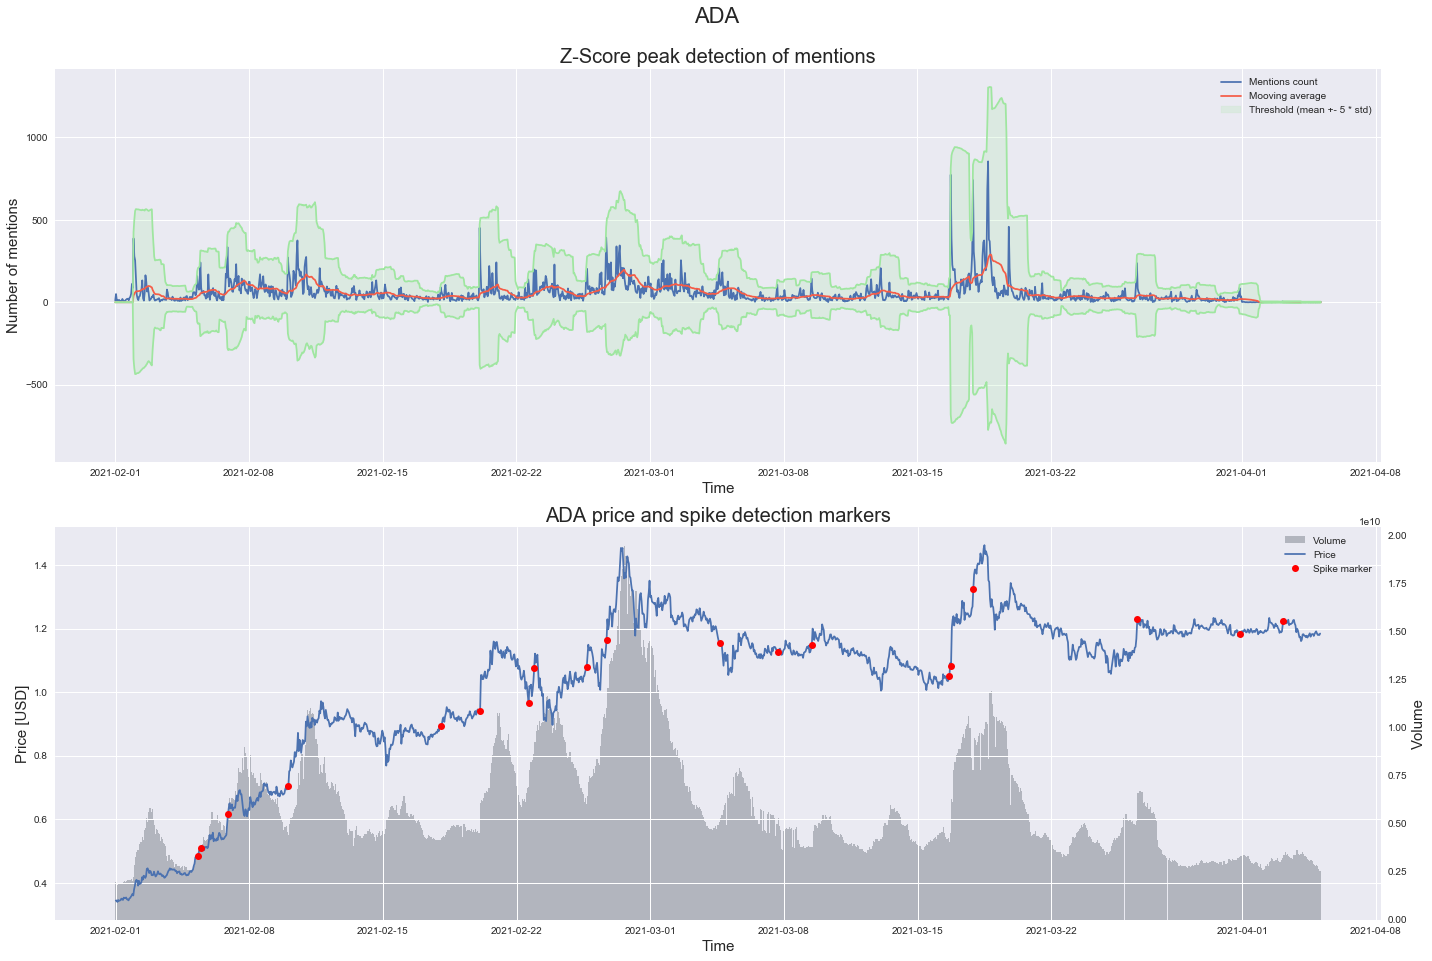

In [26]:
LAG = 24
THRESHOLD = 5
INFLUENCE = 1

fig, ax = plt.subplots(2, 1, figsize=(20, 14))

mentions_data = pd.read_csv(
    open(os.path.join(MENTIONS_COUNT_DIR, f"{TRACKED_COIN}.csv"), "r"),
    parse_dates=True,
    date_parser=date_parser,
    index_col="date",
)

price_data = pd.read_csv(
    open(os.path.join(PRICE_DATA_DIR, TRACKED_COIN, f"{TRACKED_COIN}_price.csv"), "r"),
    parse_dates=True,
    date_parser=date_parser,
    index_col="date",
)

volume_data = pd.read_csv(
    open(
        os.path.join(PRICE_DATA_DIR, TRACKED_COIN, f"{TRACKED_COIN}_volume.csv"),
        "r",
    ),
    parse_dates=True,
    date_parser=date_parser,
    index_col="date",
)

result_mentions = thresholding_algo(
    mentions_data["count"], lag=LAG, threshold=THRESHOLD, influence=INFLUENCE
)

result_price = thresholding_algo(
    price_data["price"], lag=LAG, threshold=THRESHOLD, influence=INFLUENCE
)

###########################################################################

ax[0].plot(mentions_data["count"], label="Mentions count")
ax[0].plot(
    mentions_data.index,
    result_mentions["avgFilter"],
    label="Mooving average",
    color="#f55c47",
)
ax[0].plot(
    mentions_data.index,
    result_mentions["avgFilter"] + THRESHOLD * result_mentions["stdFilter"],
    color="#9fe6a0",
)
ax[0].plot(
    mentions_data.index,
    result_mentions["avgFilter"] - THRESHOLD * result_mentions["stdFilter"],
    color="#9fe6a0",
)

ax[0].fill_between(
    mentions_data.index,
    result_mentions["avgFilter"] + THRESHOLD * result_mentions["stdFilter"],
    result_mentions["avgFilter"] - THRESHOLD * result_mentions["stdFilter"],
    color="#9fe6a0",
    alpha=0.2,
    label=f"Threshold (mean +- {THRESHOLD} * std)",
)

ax2 = ax[1].twinx()
ax2.bar(
    height=volume_data["volume"],
    x=volume_data.index,
    color=COLOR_VOLUME,
    label="Volume",
    width=0.06,
)


ax[1].plot(price_data["price"], label="Price")

for i, (sig, date) in enumerate(zip(result_mentions["signals"], mentions_data.index)):
    if sig == 1 and i < len(price_data):
        ax[1].plot(
            datetime.datetime.fromisoformat(str(date)),
            price_data.iloc[i]["price"],
            "ro",
            label="Spike marker",
        )

ax[0].set_title("Z-Score peak detection of mentions", fontsize=TITLE_SIZE)
ax[0].set_ylabel("Number of mentions", fontsize=AXES_LABELS_SIZE)
ax[0].set_xlabel("Time", fontsize=AXES_LABELS_SIZE)
ax[0].legend()

h1, l1 = ax[1].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax[1].set_title(
    f"{TRACKED_COIN} price and spike detection markers", fontsize=TITLE_SIZE
)
ax[1].set_ylabel("Price [USD]", fontsize=AXES_LABELS_SIZE)
ax[1].set_xlabel("Time", fontsize=AXES_LABELS_SIZE)
ax[1].legend(h2 + list(h1)[0:2], l2 + list(l1)[0:2])
ax[1].set_zorder(ax2.get_zorder() + 1)
ax[1].patch.set_visible(False)

ax2.grid(b=None)
ax2.patch.set_visible(True)
ax2.set_ylabel("Volume", fontsize=AXES_LABELS_SIZE)

fig.suptitle(TRACKED_COIN, fontsize=22)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Iz zgornjega grafa lahko razberemo, da predikcije niso ravno zanesljive, njihova zanesljivost pa se razlikuje od kovanca do kovanca (več grafov si najdete v [data/spikes](https://github.com/nikp00/PR21NPJSEP/tree/7556ecf72d9566c5433a2feb1fc8055d8a447143/visualization/spikes)). Težavo pri boljši evalvaciji delovanja detekcije nam je postavilo tudi trenutno stanje trga kripto valut, ki je v močnem up-trendu.

### Glavne ugotovitve

Ugotovitve nalog, ki smo jih želeli raziskati:

* Ali lahko iz objav napovemo spremembo cene?

Ugotovili smo,  da  se da kar lepo napovedati število kovancev v cirkulaciji glede na število omemb. Če se slednje poviša se tudi volumen ter obratno. Kar se tiče cene, pa je zelo težko napovedati ali bo narasla ali ne. Sklepa se lahko, da malo narase po velikem številu omemb, ker se število kovancev v populaciji načeloma poveča in s tem tudi cena.

* Poiskati povezavo med ceno in popularnostjo na Reddit/Discord

Najbolj popularni kovanci, kateri imajo največje število omemb imajo povezavo med ceno in omembami. Ko ena naraste, ji sledi tudi druga.

* Ali kateri kovanci posebej izstopajo?

Posebej so izstopali kovanci OMI, SAFEMOON in DENT, saj so imeli najbolj drastične spremembe v ceni ter volumnu v času opazovanja. Pri teh kovancih se bi dalo tudi lažje predvidit narast cen z opazovanjevm narasta količine kovancev in števila omemb.

* Kako se je spreminajalo zanimanje za kripto valute?

* Zanimanje se v časovnem oknu katerega smo opazovali ni drastično spremenilo, bilo je par večjih hitrih povečanj zanimanja, a za to so bili krivi dejavniki kot so npr. objave slavni in vplivnih ljudi na Twiterju. 
